# SIF Data Exploration

This notebook will guide you through the steps involved in collecting solar-induced fluorescence (SIF) data from NASA's Goddard Earth Sciences Data and Information Services Center (GES DISC), an online archive that stores data from the Orbiting Carbon Observatory-3 (OCO-3) spacecraft, among others.

The first code block below will simply import some necessary helper functions for exploring and displaying the data.

In [2]:
from datetime import datetime
from IPython.display import display, Markdown
import numpy as np
import os
import sys
import textwrap

# Add src directory containing helper code to sys.path
sys.path.append(os.path.abspath("../src"))


from geosif import GesDiscDownloader, plot_samples

# an additional helper function for displaying long lists
def wrapped_markdown_list(my_list, width=160):
    wrapped_text = textwrap.fill(", ".join(my_list), width=width)
    display(Markdown(f"```\n{wrapped_text}\n```"))

## I. Getting granules from GES DISC

The GES DISC stores various datasets associated with the OCO-2 and OCO-3 instruments, and in this training we will be focusing on the "SIF Lite" datasets as they have already received L2 processing to extract chlorophyll fluorescence signatures in the O2-A (757 nm) and O2-B  (771 nm) bands. Data is served through an OpenDAP interface that provides a browsing experience similar to looking at a directory tree. You can navigate this directory tree yourself here: [https://oco2.gesdisc.eosdis.nasa.gov/opendap/](https://oco2.gesdisc.eosdis.nasa.gov/opendap/)

A "granule" is an instrument data file, typically in netCDF (.nc or .nc4) format, containing a set of related variables from a time range of observations. Granules in general can be daily or subdaily in time cadence. In the case of the OCO3_L2_Lite_SIF.11r dataset we are are looking at today, individual netCDFs on GES DISC correspond to a signal day worth of instrument observations. 

The pydap module is able to lazily evaluate data in the archive without downloading it until needed, allowing us to explore the variables in a given granule before we download it. By the way, you may see a pydap warning when loading the data, this is no concern.

**If you want to look at a different dataset, change the value of the dataset variable and re-run this cell.**

In [3]:
print("Gathering datasets on GES DISC...")
dl = GesDiscDownloader()

dataset = "OCO3_L2_Lite_SIF.11r"
print(f"Getting time range for {dataset} data...")
timerange = dl.get_dataset_timerange(dataset)
print(
    f"{dataset} has time range {timerange[0].strftime('%Y-%m-%d')} to {timerange[1].strftime('%Y-%m-%d')}"
)

Gathering datasets on GES DISC...
Getting time range for OCO3_L2_Lite_SIF.11r data...
OCO3_L2_Lite_SIF.11r has time range 2019-08-06 to 2024-12-30


**If you want to look at a different date, change the date specified in `data_date` and re-run the cell below!**

In [4]:
# Get the OCO-3 SIF Lite V11r product from December 1, 2019
data_date = datetime(2019, 12, 1) # Replace with a different date if you'd like
granule = dl.get_granule_by_date(dataset, data_date)
print(f"\n\nThe {dataset} granule from {data_date.strftime('%d/%m/%Y')} has the following variables:")

wrapped_markdown_list(list(granule.keys()))

/Users/jryan/general/ARSET/GEOSIF-ARSET/venv/lib/python3.11/site-packages/pydap/handlers/dap.py:123: UserWarning: PyDAP was unable to determine the DAP protocol defaulting to DAP2 which is consider legacy and may result in slower responses. For more, see go to https://www.opendap.org/faq-page.
  _warnings.warn(




The OCO3_L2_Lite_SIF.11r granule from 01/12/2019 has the following variables:


```
Daily_SIF_757nm, Meteo_surface_pressure, Meteo_specific_humidity, Meteo_vapor_pressure_deficit, Meteo_temperature_skin, Meteo_temperature_two_meter,
Meteo_wind_speed, Longitude, SZA, SIF_740nm, Cloud_surface_albedo_abp, Cloud_delta_pressure_abp, Cloud_cloud_flag_abp, Cloud_co2_ratio, Cloud_o2_ratio,
Offset_SIF_Median_771nm, Offset_signal_histogram_757nm, Offset_SIF_Relative_SDev_771nm, Offset_SIF_Relative_SDev_757nm, Offset_SIF_Relative_Mean_771nm,
Offset_SIF_Relative_Median_771nm, Offset_SIF_Mean_771nm, Offset_signal_histogram_bins, Offset_signal_histogram_771nm, Offset_SIF_Mean_757nm,
Offset_SIF_Relative_Median_757nm, Offset_SIF_Median_757nm, Offset_SIF_Relative_Mean_757nm, Daily_SIF_740nm, Science_SIF_Unadjusted_771nm,
Science_SIF_Uncertainty_771nm, Science_SIF_Unadjusted_Relative_757nm, Science_sounding_l1b_quality_flag, Science_SIF_Relative_771nm, Science_SIF_771nm,
Science_IGBP_index, Science_SIF_757nm, Science_continuum_radiance_757nm, Science_sounding_land_fraction, Science_continuum_radiance_771nm,
Science_SIF_Unadjusted_757nm, Science_SIF_Relative_757nm, Science_SIF_Unadjusted_Relative_771nm, Science_SIF_Uncertainty_757nm, Science_daily_correction_factor,
SimplyGoodOrBadQualityFlag, Daily_SIF_771nm, Sequences_SequencesName, Sequences_SequencesMode, Sequences_SequencesId, Sequences_SequencesIndex,
Sequences_SegmentsIndex, Latitude, Diagnostics_detailed_quality_bitflag_best, Diagnostics_detailed_quality_bitflag_good,
Diagnostics_quality_bitflag_thresholds_good, Diagnostics_quality_bitflag_thresholds_best, SAz, Quality_Flag, Delta_Time, VZA, Metadata_CollectionLabel,
Metadata_BuildId, Metadata_FootprintId, Metadata_OrbitId, Metadata_MeasurementMode, Geolocation_footprint_longitude_vertices, Geolocation_sensor_azimuth_angle,
Geolocation_footprint_latitude_vertices, Geolocation_solar_azimuth_angle, Geolocation_solar_zenith_angle, Geolocation_longitude, Geolocation_latitude,
Geolocation_sensor_zenith_angle, Geolocation_altitude, Geolocation_time_tai93, VAz, SIF_Uncertainty_740nm, detailqf_dim, footprint_dim, n2, ns_17, ns_19, ns_24,
ns_5, ns_8, sequences_dim, signalbin_dim, statistics_dim, Latitude_Corners, Longitude_Corners
```

## II. Download Variables and Plot

As mentioned previously, the SIF granules contain different many different variables needed for further analysis. To get a quick sense of where observations were acquired on this particular day, we can download the Latitude and Longitude coordinates alongside the Daily_SIF_757nm variable. The value for SIF is colormapped using the viridis colormap by default.

The first time you run this code block, you will get a few warnings from cartopy notifying you that it is downloading public resources for displaying the map context, this is expected and not a problem. It may take 20-30 seconds to download all the data, so please be patient.

Note that some of the SIF samples have negative values, this is normal and expected.

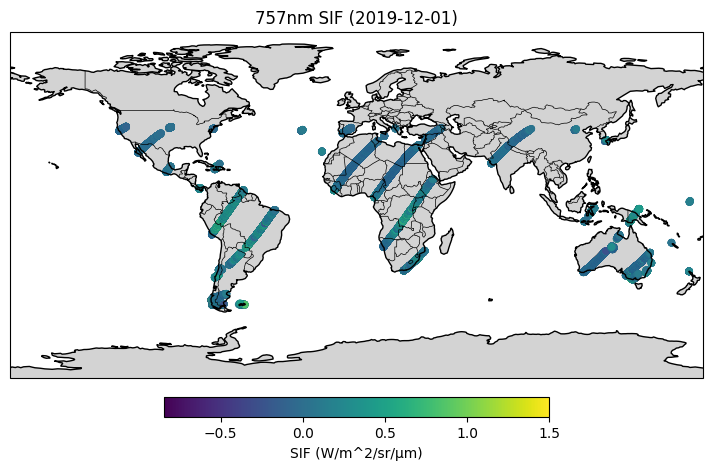

In [ ]:
def get_variable_array(variable: str):
    return np.array(granule[variable].data[:])

lat = get_variable_array("Latitude")
lon = get_variable_array("Longitude")
sif = get_variable_array("Daily_SIF_757nm")
# Setting vmax to 1.5 W/m^2/sr/μm improves the contrast of the colormapped samples
# and is based on a priori knowledge of the data range in this granule
# Remove the vmax keyword if you want matplotlib to set the data range automatically
plot_samples(
    sif, lat, lon,
    vmax=1.5,
    title=f"757nm SIF ({data_date.strftime('%Y-%m-%d')})",
    label="SIF (W/m^2/sr/μm)"
)

## III. Download a set of Data

Now we can download a set of granules across a date range to perform analysis. After gathering the filesizes of the granules, the code will prompt you to confirm the amount of data you are about to download before proceeding. The following cell will download one month of data, but you can try different time ranges.

**Troubleshooting**: Some file downloads may fail. You can add a keyword at the end of the list of arguments, `parallel=True`

In [ ]:
# Downloading data from 2020-Apr-1 to 2020-May-1.
dl.download_timerange(
        dataset,
        datetime(2020, 5, 2),
        datetime(2020, 6, 1),
        outpath="../data",
        parallel=True,
    )

After this operation, 372 MB of additional disk space will be used.


Failed to download a file: Failed to download https://oco2.gesdisc.eosdis.nasa.gov/data/OCO3_DATA/OCO3_L2_Lite_SIF.11r/2020/oco3_LtSIF_200504_B11074Ar_241022153958s.nc4: 503 Server Error: Service Unavailable for url: https://oco2.gesdisc.eosdis.nasa.gov/data/OCO3_DATA/OCO3_L2_Lite_SIF.11r/2020/oco3_LtSIF_200504_B11074Ar_241022153958s.nc4
Failed to download a file: Failed to download https://oco2.gesdisc.eosdis.nasa.gov/data/OCO3_DATA/OCO3_L2_Lite_SIF.11r/2020/oco3_LtSIF_200509_B11074Ar_241022154058s.nc4: 503 Server Error: Service Unavailable for url: https://oco2.gesdisc.eosdis.nasa.gov/data/OCO3_DATA/OCO3_L2_Lite_SIF.11r/2020/oco3_LtSIF_200509_B11074Ar_241022154058s.nc4
Failed to download a file: Failed to download https://oco2.gesdisc.eosdis.nasa.gov/data/OCO3_DATA/OCO3_L2_Lite_SIF.11r/2020/oco3_LtSIF_200508_B11074Ar_241022154116s.nc4: 503 Server Error: Service Unavailable for url: https://oco2.gesdisc.eosdis.nasa.gov/data/OCO3_DATA/OCO3_L2_Lite_SIF.11r/2020/oco3_LtSIF_200508_B11074A

[PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200514_B11074Ar_241022154101s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200516_B11074Ar_241022154145s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200511_B11074Ar_241022153742s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200503_B11074Ar_241022154039s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200517_B11074Ar_241022153953s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200518_B11074Ar_241022154152s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200507_B11074Ar_241022154040s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200519_B11074Ar_241022153919s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/data/oco3_LtSIF_200520_B11074Ar_241022154158s.nc4'),
 PosixPath('/Users/jryan/general/ARSET/GEOSIF-ARSET/dat